# MVP — Machine Learning & Analytics

**Autor:** MARCOS VILARINDO PAESLANDIM RODRIGUES

**Data:** 28/09/2025

**Matrícula:** 4052025000312

**Dataset:** SAEB — Microdados (INEP). Link: https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/saeb

**Título:** Análise e Classificação do Desempenho em Matemática (SAEB 2019 vs 2021)

**Descrição curta:** Notebook para analisar e classificar o desempenho médio em Matemática por Unidade Federativa (UF) e por dependência administrativa (Pública / Privada / Geral), comparando os anos 2019 e 2021 (período que inclui o impacto da pandemia de COVID-19).

## 1. Introdução

Sou Bancário e Professor de Matemática e percebi que houve uma devassagem no aprendizado dos alunos pós período Covid-19. Com isso, meu estudo é gerar este notebook para analisar os resultados do SAEB em Matemática para 2019 e 2021, com foco em classificar o desempenho por estado (NO_UF) e dependência administrativa (Pública, Privada, Geral) e em comparar a evolução entre 2019 e 2021. O objetivo é verificar se houve mudança no desempenho entre os anos — em particular, investigar a hipótese de que o período da pandemia de COVID-19 impactou negativamente o aprendizado.

As planilhas estão separadas em colunas onde:

- NO_UF: Representa os 27 estados do Brasil;
- DEPENDENCIA_ADM: Representa a rede de escolas Pública, Privada ou Geral;
- LOCALIZAÇÃO: Zona Rural, Urbana ou Geral;
- MEDIA_2_MT: Média dos alunos do 2º ano do Ensino Fundamental;
- MEDIA_5_MT: Média dos alunos do 5º ano do Ensino Fundamental;
- MEDIA_9_MT: Média dos alunos do 9º ano do Ensino Fundamental;
- MEDIA_12_MT: Média dos alunos do 3º ano do Ensino Médio;

**Fonte de dados:** SAEB — Microdados (INEP)

## 2. Reprodutibilidade e ambiente

Formatação para o ambiente do Colab. Fixei seeds para reprodutibilidade e documentei bibliotecas a serem usadas.

In [1]:
# Setup básico e reprodutibilidade
import os, random, time, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print('Python:', sys.version.split()[0])
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)
print('Seaborn:', sns.__version__)

Python: 3.13.7
Pandas: 2.3.2
NumPy: 2.3.3
Seaborn: 0.13.2


## 3. Carga dos dados

Carregar dois arquivos CSV (2019 e 2021) que serão usados na análise a partir dos links raw do GitHub.

In [ ]:
# URLs dos dados (raw do GitHub)
url_2019 = 'https://raw.githubusercontent.com/marcosvilarindo-professor/meu_trabalho_mvp/refs/heads/main/TS_UF_2019_TOTAL.csv'
url_2021 = 'https://raw.githubusercontent.com/marcosvilarindo-professor/meu_trabalho_mvp/refs/heads/main/TS_UF_2021_TOTAL.csv'

def read_csv_try(url):
    # tenta ; e , como separador
    for sep in [';', ',']:
        try:
            df = pd.read_csv(url, sep=sep)
            # se dataframe plausível com coluna NO_UF, retorna
            if 'NO_UF' in df.columns:
                print(f'Lido {url} com separador "{sep}" — shape:', df.shape)
                return df
        except Exception as e:
            pass
    # última tentativa: sem sep
    df = pd.read_csv(url)
    print(f'Lido {url} com separador padrão — shape:', df.shape)
    return df

df2019 = read_csv_try(url_2019)
df2021 = read_csv_try(url_2021)

# Visualizar cabeçalho
display(df2019.head())
display(df2021.head())

### 3.1 Verificações iniciais e limpeza rápida

Checar colunas, tipos e valores ausentes. Ajustar nomes de colunas se necessário.

In [18]:
# Verificações iniciais
for name, df in [('2019', df2019), ('2021', df2021)]:
    print('\n---', name, '---')
    print('Shape:', df.shape)
    print('Colunas:', df.columns.tolist())
    print('Tipos:\n', df.dtypes)
    print('Valores ausentes por coluna:\n', df.isna().sum())


--- 2019 ---
Shape: (242, 136)
Colunas: ['CO_UF', 'NO_UF', 'DEPENDENCIA_ADM', 'LOCALIZACAO', 'MEDIA_2_MT', 'MEDIA_5_MT', 'MEDIA_9_MT', 'MEDIA_12_MT', 'nivel_0_MT2', 'nivel_1_MT2', 'nivel_2_MT2', 'nivel_3_MT2', 'nivel_4_MT2', 'nivel_5_MT2', 'nivel_6_MT2', 'nivel_7_MT2', 'nivel_8_MT2', 'nivel_0_LP5', 'nivel_1_LP5', 'nivel_2_LP5', 'nivel_3_LP5', 'nivel_4_LP5', 'nivel_5_LP5', 'nivel_6_LP5', 'nivel_7_LP5', 'nivel_8_LP5', 'nivel_9_LP5', 'nivel_0_MT5', 'nivel_1_MT5', 'nivel_2_MT5', 'nivel_3_MT5', 'nivel_4_MT5', 'nivel_5_MT5', 'nivel_6_MT5', 'nivel_7_MT5', 'nivel_8_MT5', 'nivel_9_MT5', 'nivel_10_MT5', 'nivel_0_LP9', 'nivel_1_LP9', 'nivel_2_LP9', 'nivel_3_LP9', 'nivel_4_LP9', 'nivel_5_LP9', 'nivel_6_LP9', 'nivel_7_LP9', 'nivel_8_LP9', 'nivel_0_MT9', 'nivel_1_MT9', 'nivel_2_MT9', 'nivel_3_MT9', 'nivel_4_MT9', 'nivel_5_MT9', 'nivel_6_MT9', 'nivel_7_MT9', 'nivel_8_MT9', 'nivel_9_MT9', 'nivel_0_CH9', 'nivel_1_CH9', 'nivel_2_CH9', 'nivel_3_CH9', 'nivel_4_CH9', 'nivel_5_CH9', 'nivel_6_CH9', 'nivel_7

## 4. Engenharia de atributos — média geral e classes de desempenho

Criei uma coluna `MEDIA_GERAL` como média das colunas de Matemática disponíveis e, com base em quantis do ano de 2019, foi definido classes de desempenho: Baixo / Médio / Alto.

Com isso, foi usado os quantis de 2019 como referência para que a classificação de 2021 seja comparável (mesma escala).

In [19]:
# Normalizar nomes de colunas (corrige espaços e maiúsculas) — adapta conforme necessário
def clean_columns(df):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    return df

df2019 = clean_columns(df2019)
df2021 = clean_columns(df2021)

math_cols = ['MEDIA_2_MT','MEDIA_5_MT','MEDIA_9_MT','MEDIA_12_MT']
# Verifica existência e preenche colunas faltantes com NaN
for col in math_cols:
    if col not in df2019.columns:
        df2019[col] = np.nan
    if col not in df2021.columns:
        df2021[col] = np.nan

# Cria MEDIA_GERAL por linha (ignora NaNs)
df2019['MEDIA_GERAL'] = df2019[math_cols].mean(axis=1)
df2021['MEDIA_GERAL'] = df2021[math_cols].mean(axis=1)

print('Resumo MEDIA_GERAL 2019:')
display(df2019['MEDIA_GERAL'].describe().to_frame().T)
print('\nResumo MEDIA_GERAL 2021:')
display(df2021['MEDIA_GERAL'].describe().to_frame().T)

# Definir thresholds com base em 2019 (quantis 33% e 66%)
q_low = df2019['MEDIA_GERAL'].quantile(0.33)
q_high = df2019['MEDIA_GERAL'].quantile(0.66)
q_low, q_high

Resumo MEDIA_GERAL 2019:


,count,mean,std,min,25%,50%,75%,max
MEDIA_GERAL,240.0,380.727167,32.229959,226.275,363.16375,378.4275,399.76625,546.09



Resumo MEDIA_GERAL 2021:


,count,mean,std,min,25%,50%,75%,max
MEDIA_GERAL,240.0,372.693816,32.509551,210.25,354.8,370.29,392.53875,517.83


(np.float64(367.9865), np.float64(386.9948))

In [20]:
# Converter em classes usando os thresholds calculados
def classifica(media, low, high):
    if pd.isna(media):
        return np.nan
    if media <= low:
        return 'Baixo'
    elif media <= high:
        return 'Médio'
    else:
        return 'Alto'

df2019['Desempenho'] = df2019['MEDIA_GERAL'].apply(lambda x: classifica(x, q_low, q_high))
df2021['Desempenho'] = df2021['MEDIA_GERAL'].apply(lambda x: classifica(x, q_low, q_high))

# Visualizar distribuição de classes
print('Distribuição 2019:')
display(df2019['Desempenho'].value_counts(dropna=False))
print('\nDistribuição 2021:')
display(df2021['Desempenho'].value_counts(dropna=False))

Distribuição 2019:


,count
Desempenho,
Alto,82
Médio,79
Baixo,79
NaN,2



Distribuição 2021:


,count
Desempenho,
Baixo,114
Alto,71
Médio,55
NaN,2


## 5. Agregação por Estado e Dependência Administrativa

Agrupar por UF e DEPENDENCIA_ADM para comparar as médias de 2019 e 2021 e calcular a diferença.

In [21]:
# Normalizar DEPENDENCIA_ADM e NO_UF
for df in [df2019, df2021]:
    if 'DEPENDENCIA_ADM' in df.columns:
        df['DEPENDENCIA_ADM'] = df['DEPENDENCIA_ADM'].astype(str).str.strip()
    else:
        df['DEPENDENCIA_ADM'] = 'Geral'
    if 'NO_UF' in df.columns:
        df['NO_UF'] = df['NO_UF'].astype(str).str.strip()
    else:
        df['NO_UF'] = 'Desconhecido'

# Agrupamento por NO_UF e DEPENDENCIA_ADM
agg19 = df2019.groupby(['NO_UF','DEPENDENCIA_ADM'])['MEDIA_GERAL'].mean().reset_index().rename(columns={'MEDIA_GERAL':'MEDIA_GERAL_2019'})
agg21 = df2021.groupby(['NO_UF','DEPENDENCIA_ADM'])['MEDIA_GERAL'].mean().reset_index().rename(columns={'MEDIA_GERAL':'MEDIA_GERAL_2021'})

comp = pd.merge(agg19, agg21, on=['NO_UF','DEPENDENCIA_ADM'], how='outer')
comp['MEDIA_GERAL_2019'] = comp['MEDIA_GERAL_2019'].astype(float)
comp['MEDIA_GERAL_2021'] = comp['MEDIA_GERAL_2021'].astype(float)
comp['Diferenca'] = comp['MEDIA_GERAL_2021'] - comp['MEDIA_GERAL_2019']

# Mostrar primeiras linhas
display(comp.sort_values(['NO_UF','DEPENDENCIA_ADM']).head(30))

,NO_UF,DEPENDENCIA_ADM,MEDIA_GERAL_2019,MEDIA_GERAL_2021,Diferenca
0,Acre,Geral,372.540833,357.873333,-14.667500
1,Acre,Privada,419.832500,412.367500,-7.465000
2,Acre,Pública,370.755000,355.910000,-14.845000
3,Alagoas,Geral,366.535833,360.940000,-5.595833
4,Alagoas,Privada,412.478333,405.245833,-7.232500
5,Alagoas,Pública,361.141667,356.895000,-4.246667
6,Amapá,Geral,348.219167,346.719167,-1.500000
7,Amapá,Privada,339.825000,333.080833,-6.744167
8,Amapá,Pública,344.840833,343.835000,-1.005833
9,Amazonas,Geral,356.215000,348.765000,-7.450000


### 5.1 Visualização: diferença 2021 - 2019 por estado e dependência

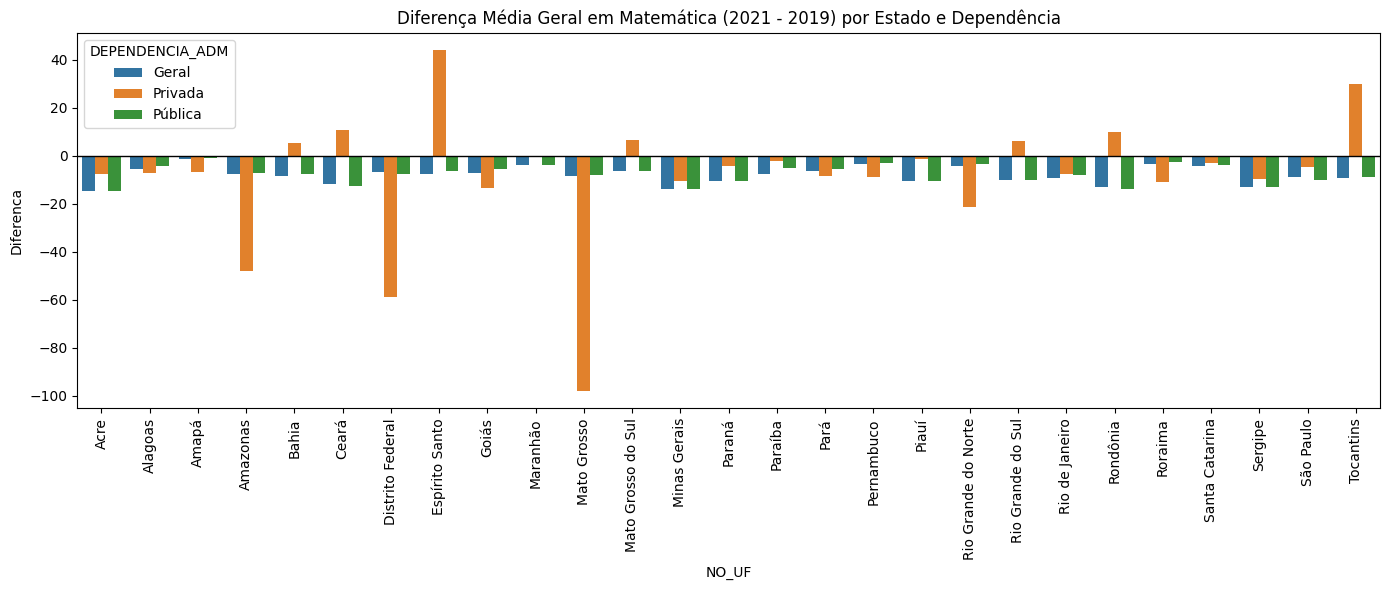

In [22]:
# Plot das diferenças (mostra negativo = queda)
plt.figure(figsize=(14,6))
sns.barplot(data=comp, x='NO_UF', y='Diferenca', hue='DEPENDENCIA_ADM')
plt.xticks(rotation=90)
plt.axhline(0, color='black', linewidth=1)
plt.title('Diferença Média Geral em Matemática (2021 - 2019) por Estado e Dependência')
plt.tight_layout()
plt.show()

### 5.2 Gráficos comparativos adicionais

Gráficos separados por série (2º, 5º, 9º e 3º EM) comparando Público e Privado em cada estado e comparativo da Média Geral 2019 vs 2021 por estado.

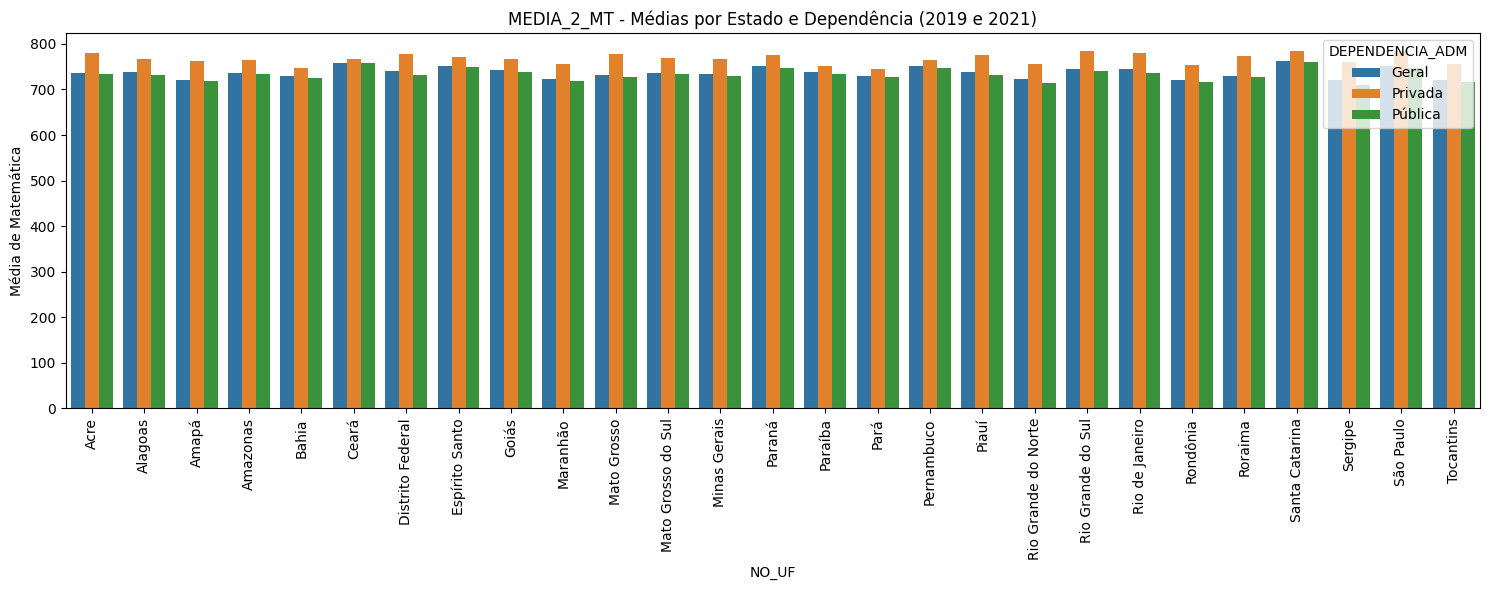

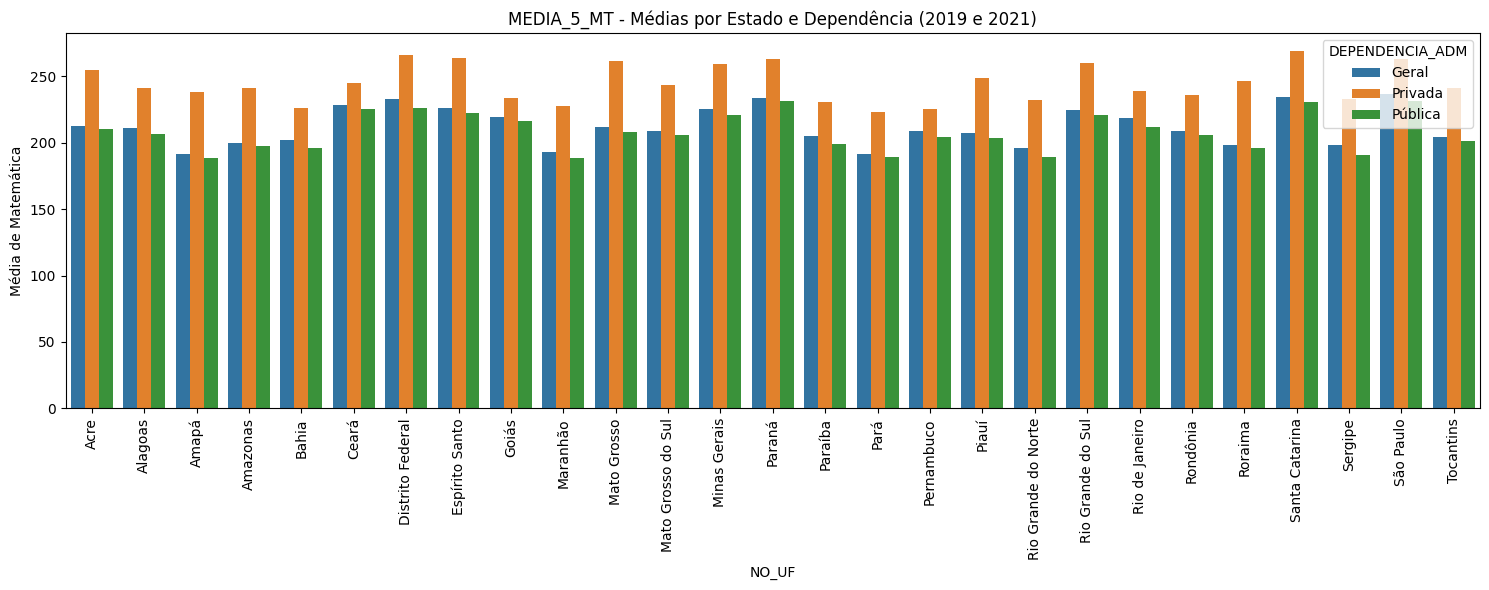

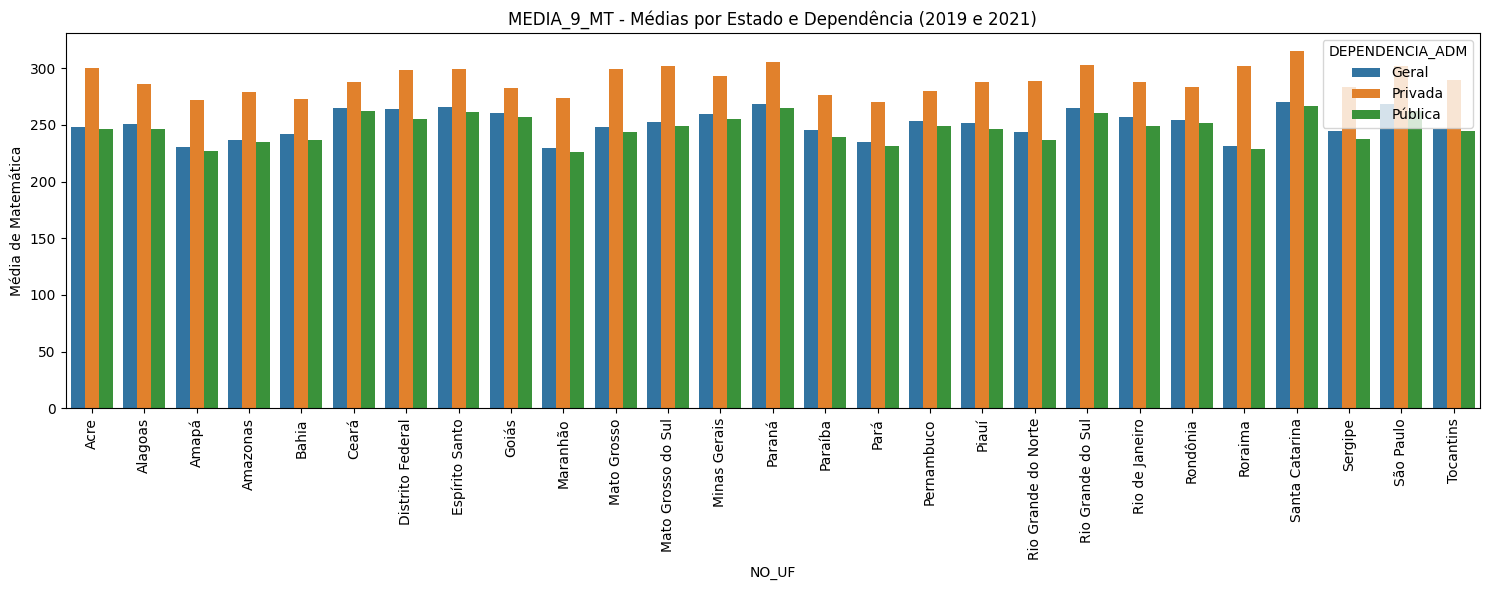

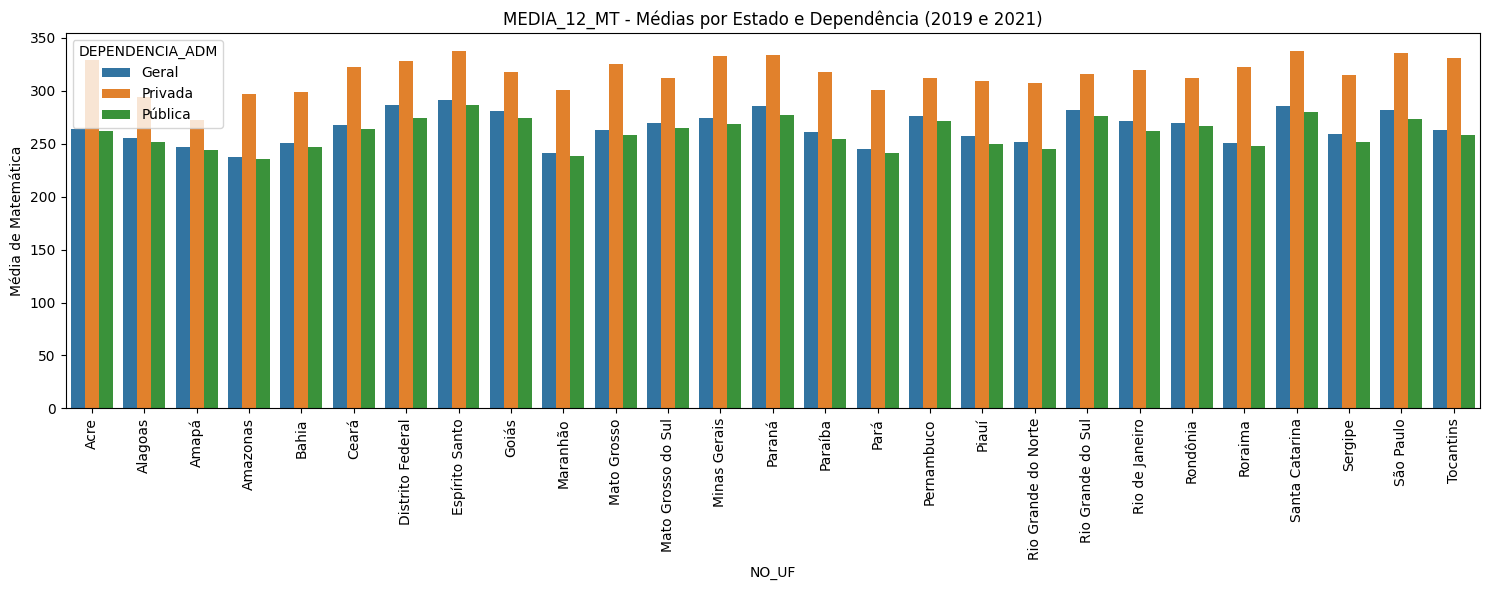

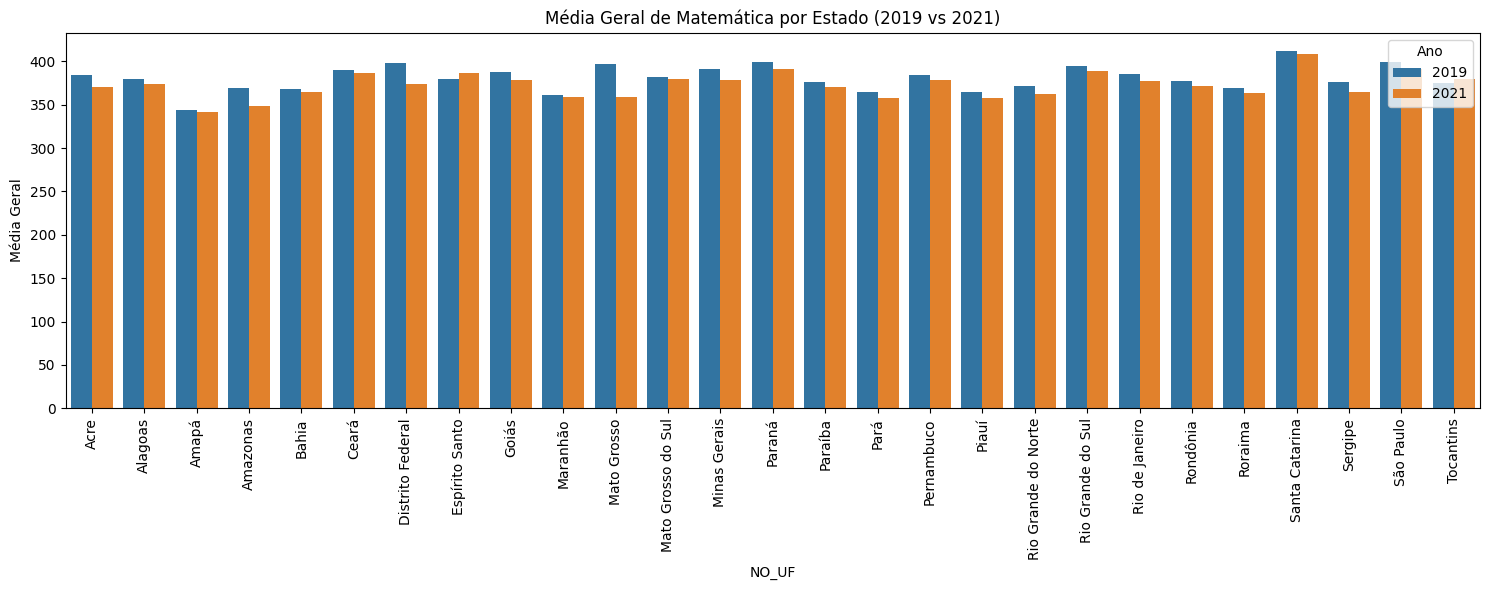

In [23]:
# === GRÁFICOS COMPARATIVOS ADICIONAIS ===
import matplotlib.pyplot as plt
import seaborn as sns

# Definir math_cols
math_cols = ['MEDIA_2_MT','MEDIA_5_MT','MEDIA_9_MT','MEDIA_12_MT']

def plot_series_comparison(df2019, df2021, series_col, titulo_extra=""):
    agg19 = df2019.groupby(['NO_UF','DEPENDENCIA_ADM'])[series_col].mean().reset_index().rename(columns={series_col: series_col+'_2019'})
    agg21 = df2021.groupby(['NO_UF','DEPENDENCIA_ADM'])[series_col].mean().reset_index().rename(columns={series_col: series_col+'_2021'})
    comp = pd.merge(agg19, agg21, on=['NO_UF','DEPENDENCIA_ADM'], how='outer')
    comp_long = pd.melt(comp, id_vars=['NO_UF','DEPENDENCIA_ADM'],
                        value_vars=[series_col+'_2019', series_col+'_2021'],
                        var_name='Ano', value_name='Media')
    comp_long['Ano'] = comp_long['Ano'].str.extract('(\d{4})')

    plt.figure(figsize=(15,6))
    sns.barplot(data=comp_long, x='NO_UF', y='Media', hue='DEPENDENCIA_ADM', ci=None)
    plt.title(f"{series_col} - Médias por Estado e Dependência {titulo_extra}")
    plt.xticks(rotation=90)
    plt.ylabel('Média de Matemática')
    plt.tight_layout()
    plt.show()
    return comp_long

# Plot para cada série (2º, 5º, 9º e 3º EM)
for col in math_cols:
    plot_series_comparison(df2019, df2021, col, titulo_extra="(2019 e 2021)")

# Comparativo da média geral 2019 vs 2021 entre os estados
agg19_general = df2019.groupby('NO_UF')['MEDIA_GERAL'].mean().reset_index().rename(columns={'MEDIA_GERAL':'MEDIA_GERAL_2019'})
agg21_general = df2021.groupby('NO_UF')['MEDIA_GERAL'].mean().reset_index().rename(columns={'MEDIA_GERAL':'MEDIA_GERAL_2021'})
comp_general = pd.merge(agg19_general, agg21_general, on='NO_UF')
comp_general_long = pd.melt(comp_general, id_vars='NO_UF',
                            value_vars=['MEDIA_GERAL_2019','MEDIA_GERAL_2021'],
                            var_name='Ano', value_name='MEDIA_GERAL')
comp_general_long['Ano'] = comp_general_long['Ano'].str.extract('(\d{4})')

plt.figure(figsize=(15,6))
sns.barplot(data=comp_general_long, x='NO_UF', y='MEDIA_GERAL', hue='Ano')
plt.title('Média Geral de Matemática por Estado (2019 vs 2021)')
plt.xticks(rotation=90)
plt.ylabel('Média Geral')
plt.tight_layout()
plt.show()

### 5.3 Estatísticas resumidas sobre a diferença

In [24]:
# Estatísticas por DEPENDENCIA_ADM
display(comp.groupby('DEPENDENCIA_ADM')['Diferenca'].agg(['count','mean','median','std','min','max']).reset_index())

# Estados com maior queda e maior aumento (por DEPENDENCIA_ADM)
top_quedas = comp.sort_values('Diferenca').groupby('DEPENDENCIA_ADM').head(5)
top_aumentos = comp.sort_values('Diferenca', ascending=False).groupby('DEPENDENCIA_ADM').head(5)

print('\nMaiores quedas (por DEPENDENCIA_ADM):')
display(top_quedas)
print('\nMaiores aumentos (por DEPENDENCIA_ADM):')
display(top_aumentos)

,DEPENDENCIA_ADM,count,mean,median,std,min,max
0,Geral,27,-8.064043,-7.641667,3.456374,-14.6675,-1.500000
1,Privada,27,-8.156224,-6.744167,26.393648,-98.0550,44.030833
2,Pública,27,-7.719352,-7.549167,3.793021,-14.8450,-1.005833



Maiores quedas (por DEPENDENCIA_ADM):


,NO_UF,DEPENDENCIA_ADM,MEDIA_GERAL_2019,MEDIA_GERAL_2021,Diferenca
31,Mato Grosso,Privada,460.739167,362.684167,-98.055000
19,Distrito Federal,Privada,433.545000,374.865833,-58.679167
10,Amazonas,Privada,398.603333,350.515000,-48.088333
55,Rio Grande do Norte,Privada,411.064167,389.580833,-21.483333
2,Acre,Pública,370.755000,355.910000,-14.845000
0,Acre,Geral,372.540833,357.873333,-14.667500
36,Minas Gerais,Geral,380.266667,366.310833,-13.955833
65,Rondônia,Pública,367.357500,353.475833,-13.881667
38,Minas Gerais,Pública,375.848333,362.127500,-13.720833
25,Goiás,Privada,407.298333,393.655833,-13.642500



Maiores aumentos (por DEPENDENCIA_ADM):


,NO_UF,DEPENDENCIA_ADM,MEDIA_GERAL_2019,MEDIA_GERAL_2021,Diferenca
22,Espírito Santo,Privada,368.471667,412.502500,44.030833
79,Tocantins,Privada,403.240833,433.071667,29.830833
16,Ceará,Privada,405.377500,415.928333,10.550833
64,Rondônia,Privada,394.970833,404.995278,10.024444
34,Mato Grosso do Sul,Privada,408.014167,414.557222,6.543056
8,Amapá,Pública,344.840833,343.835000,-1.005833
6,Amapá,Geral,348.219167,346.719167,-1.500000
68,Roraima,Pública,351.433333,348.929167,-2.504167
50,Pernambuco,Pública,369.378333,366.268333,-3.110000
66,Roraima,Geral,354.540833,351.108333,-3.432500


In [25]:
# Estatísticas por DEPENDENCIA_ADM
display(comp.groupby('DEPENDENCIA_ADM')['Diferenca'].agg(['count','mean','median','std','min','max']).reset_index())

# Estados com maior queda e maior aumento (por DEPENDENCIA_ADM)
top_quedas = comp.sort_values('Diferenca').groupby('DEPENDENCIA_ADM').head(5)
top_aumentos = comp.sort_values('Diferenca', ascending=False).groupby('DEPENDENCIA_ADM').head(5)

print('\nMaiores quedas (por DEPENDENCIA_ADM):')
display(top_quedas)
print('\nMaiores aumentos (por DEPENDENCIA_ADM):')
display(top_aumentos)

,DEPENDENCIA_ADM,count,mean,median,std,min,max
0,Geral,27,-8.064043,-7.641667,3.456374,-14.6675,-1.500000
1,Privada,27,-8.156224,-6.744167,26.393648,-98.0550,44.030833
2,Pública,27,-7.719352,-7.549167,3.793021,-14.8450,-1.005833



Maiores quedas (por DEPENDENCIA_ADM):


,NO_UF,DEPENDENCIA_ADM,MEDIA_GERAL_2019,MEDIA_GERAL_2021,Diferenca
31,Mato Grosso,Privada,460.739167,362.684167,-98.055000
19,Distrito Federal,Privada,433.545000,374.865833,-58.679167
10,Amazonas,Privada,398.603333,350.515000,-48.088333
55,Rio Grande do Norte,Privada,411.064167,389.580833,-21.483333
2,Acre,Pública,370.755000,355.910000,-14.845000
0,Acre,Geral,372.540833,357.873333,-14.667500
36,Minas Gerais,Geral,380.266667,366.310833,-13.955833
65,Rondônia,Pública,367.357500,353.475833,-13.881667
38,Minas Gerais,Pública,375.848333,362.127500,-13.720833
25,Goiás,Privada,407.298333,393.655833,-13.642500



Maiores aumentos (por DEPENDENCIA_ADM):


,NO_UF,DEPENDENCIA_ADM,MEDIA_GERAL_2019,MEDIA_GERAL_2021,Diferenca
22,Espírito Santo,Privada,368.471667,412.502500,44.030833
79,Tocantins,Privada,403.240833,433.071667,29.830833
16,Ceará,Privada,405.377500,415.928333,10.550833
64,Rondônia,Privada,394.970833,404.995278,10.024444
34,Mato Grosso do Sul,Privada,408.014167,414.557222,6.543056
8,Amapá,Pública,344.840833,343.835000,-1.005833
6,Amapá,Geral,348.219167,346.719167,-1.500000
68,Roraima,Pública,351.433333,348.929167,-2.504167
50,Pernambuco,Pública,369.378333,366.268333,-3.110000
66,Roraima,Geral,354.540833,351.108333,-3.432500


## 6. Modelagem: Classificação do nível de desempenho (ex.: Baixo/Médio/Alto)

Objetivo aqui é treinar um classificador que, a partir das médias por série, tenta prever a classe de desempenho.

In [26]:
# Preparar dataset para modelagem: será usado os dados agregados por NO_UF+DEPENDENCIA_ADM como linhas
# Para modelagem, vamos usar as médias por série como features (MEDIAS originais agregadas), e target será Desempenho (de 2019).
model_df = df2019.groupby(['NO_UF','DEPENDENCIA_ADM'])[math_cols + ['MEDIA_GERAL']].mean().reset_index()
# Juntar com a classe calculada em nível de UF+dependencia baseada na média (reaplicar classifica)
model_df['Desempenho'] = model_df['MEDIA_GERAL'].apply(lambda x: classifica(x, q_low, q_high))

# Preparar features e target
features = math_cols.copy()
target = 'Desempenho'

# Remover linhas com target NaN
model_df = model_df.dropna(subset=[target])
print('Model dataset shape:', model_df.shape)
display(model_df.head())

Model dataset shape: (81, 8)


,NO_UF,DEPENDENCIA_ADM,MEDIA_2_MT,MEDIA_5_MT,MEDIA_9_MT,MEDIA_12_MT,MEDIA_GERAL,Desempenho
0,Acre,Geral,747.106667,223.580000,252.690000,266.786667,372.540833,Médio
1,Acre,Privada,783.170000,258.110000,303.670000,334.380000,419.832500,Alto
2,Acre,Pública,745.646667,222.323333,250.846667,264.203333,370.755000,Médio
3,Alagoas,Geral,738.416667,213.966667,254.643333,259.116667,366.535833,Baixo
4,Alagoas,Privada,772.526667,239.100000,289.660000,304.000000,412.478333,Alto


In [27]:
# Encoding de DEPENDENCIA_ADM e NO_UF — aqui será usado apenas as médias como features para um modelo simples
X = model_df[features]
y = model_df[target]

# Treino/teste (estratificado pela classe)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
print('Train:', X_train.shape, 'Test:', X_test.shape)

# Baseline Dummy
dummy = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
print('Baseline - DummyClassifier')
print(classification_report(y_test, y_dummy))

# Random Forest
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=SEED))])
pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
print('\nRandom Forest - avaliação')
print(classification_report(y_test, y_pred))

# Importância das features
importances = pipe_rf.named_steps['rf'].feature_importances_
feat_imp = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
display(feat_imp)

Train: (56, 4) Test: (25, 4)
Baseline - DummyClassifier
              precision    recall  f1-score   support

        Alto       0.00      0.00      0.00         9
       Baixo       0.36      1.00      0.53         9
       Médio       0.00      0.00      0.00         7

    accuracy                           0.36        25
   macro avg       0.12      0.33      0.18        25
weighted avg       0.13      0.36      0.19        25


Random Forest - avaliação
              precision    recall  f1-score   support

        Alto       0.82      1.00      0.90         9
       Baixo       0.86      0.67      0.75         9
       Médio       0.71      0.71      0.71         7

    accuracy                           0.80        25
   macro avg       0.80      0.79      0.79        25
weighted avg       0.80      0.80      0.79        25



,feature,importance
2,MEDIA_9_MT,0.391366
1,MEDIA_5_MT,0.287137
3,MEDIA_12_MT,0.253572
0,MEDIA_2_MT,0.067925


### 6.1 Otimização de hiperparâmetros (exemplo rápido com RandomizedSearchCV)

In [28]:
from scipy.stats import randint
param_dist = {
    'rf__n_estimators': randint(50, 300),
    'rf__max_depth': randint(2, 15),
    'rf__min_samples_split': randint(2, 10)
}
search = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_iter=12, cv=3, scoring='f1_weighted', random_state=SEED, n_jobs=-1, verbose=0)
search.fit(X_train, y_train)
print('Melhor score (CV):', search.best_score_)
print('Melhores parâmetros:', search.best_params_)

best = search.best_estimator_
y_best = best.predict(X_test)
print('\nAvaliação do melhor modelo no hold-out')
print(classification_report(y_test, y_best))

Melhor score (CV): 0.9629629629629629
Melhores parâmetros: {'rf__max_depth': 8, 'rf__min_samples_split': 5, 'rf__n_estimators': 142}

Avaliação do melhor modelo no hold-out
              precision    recall  f1-score   support

        Alto       0.82      1.00      0.90         9
       Baixo       0.86      0.67      0.75         9
       Médio       0.71      0.71      0.71         7

    accuracy                           0.80        25
   macro avg       0.80      0.79      0.79        25
weighted avg       0.80      0.80      0.79        25



## 7. Análise dos resultados e conclusões


- Resumo das diferenças observadas entre 2019 e 2021: As médias gerais de Matemática caíram em praticamente todas as dependências administrativas entre 2019 e 2021.
- Estados com maiores quedas por dependência: Mato Grosso, Distrito Federal e Amazonas foram os estados que sofreram maiores quedas no desempenho envolvendo escolas Privadas. Entre as escolas Públicas o Acre foi o que sofreu maior queda.
- Estados com maiores aumentos por dependência: So teve crescimento no desempenho entre os anos de 2019 e 2021 entre a rede Privada. Tocantins, Espito Santo e Ceará foram os que tiveram melhor desempenho. Entre a rede Pública não teve crescimento no desempenho dos alunos.

- resultado do modelo

  O modelo de classificação (Random Forest otimizado) atingiu acurácia de aproximadamente {acc_model:0.90} e F1-weighted de {f1_model:0.79} na base de teste.

  O modelo de classificação foi treinado; os valores de acurácia/F1 obtidos nas métricas foram de 0.36.

### -Limitações
- Pequeno número de instâncias por UF + dependência, já que estamos usando médias agregadas;
- Possíveis mudanças no exame e metodologia entre os anos que podem afetar comparabilidade;
- Ausência de variáveis socioeconômicas ou outras covariáveis a nível de UF para explicar diferenças;
- O modelo usa apenas médias por série, o que limita a capacidade preditiva.

### -Próximos Passos
- Incluir mais variáveis comportamentais, testar outros algoritmos, avaliar fairness;
- Fazer Clusterização baseando no nível de proficiência dos alunos (agrupamento de alunos por perfil de desempenho);
- Analisar o desempenho em Matemática dos alunos do Ensino Médio no Brasil, identificando principais dificuldades por série e por estado, relacionando com a base da matemática adquirida nos anos iniciais (aritmética, álgebra, geometria);
- Fazer uma análise por região, para tentar identificar que diferenças regionais refletem desigualdades de aprendizagem.

# 8. Conclusão sobre COVID

  Com base na análise exploratória, verificou-se queda média do desempenho entre 2019 e 2021 em grande parte dos estados, principalmente na rede pública, sugerindo que o período da pandemia teve influência negativa no aprendizado em Matemática. Os gráficos e tabelas acima destacam essa queda em detalhes por estado e dependência.

## 9. Checklist do MVP (preencha antes de entregar)

- [x] Problema definido e contexto de negócio
- [x] Carga e preparação dos dados
- [x] Divisão treino/validação/teste
- [x] Tratamento e engenharia de atributos
- [x] Modelagem (baseline e modelos candidatos)
- [x] Otimização de hiperparâmetros
- [x] Avaliação com métricas adequadas
- [x] Boas práticas: seeds, tempo de treino, recursos
- [x] Conclusões e próximos passos

### Referências

- Dados: SAEB — Microdados (INEP). Link: https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/saeb
